In [24]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style('whitegrid')

In [25]:
import operator

In [26]:
summary = pd.read_csv('summary_stats.csv')
df = pd.read_excel('XYZ-1.xlsx', 'Data')
demand = df[6:]

In [27]:
summary

,Purchase Cost,Lead Time,Size,Selling Price,Starting Stock,Mean,Std Dev,Co,Ch,Probability,Demand_lead
0,12,9,0.570,16.1,2750,103.501805,37.317994,1000,20,0.756831,705
1,7,6,0.052,8.6,22500,648.551913,26.446797,1200,20,1.000000,3891
2,6,16,0.530,10.2,5200,201.677043,31.079301,1000,20,0.702186,2266
3,37,22,1.050,68.0,1400,150.068965,3.215598,1200,20,0.237705,785


In [28]:
demand

,Product,1,2,3,4
6,0,90,610,204,153
7,1,94,685,244,147
8,2,0,649,197,0
9,3,110,667,0,0
10,4,106,663,228,0
...,...,...,...,...,...
367,361,126,654,255,0
368,362,0,662,182,0
369,363,70,671,192,0
370,364,0,651,177,0


In [29]:
class Product:
    def __init__(self, i):
        """
        :type i: int - Product number
        """
        self.i = i
        self.unit_cost = summary['Purchase Cost'].iloc[i - 1]
        self.lead_time = summary['Lead Time'].iloc[i - 1]
        self.size = summary['Size'].iloc[i - 1]
        self.selling_price = summary['Selling Price'].iloc[i - 1]
        self.holding_cost = summary['Ch'].iloc[i - 1]
        self.ordering_cost = summary['Co'].iloc[i - 1]
        self.probability = summary['Probability'].iloc[i - 1]
        self.starting_stock = summary['Starting Stock'].iloc[i - 1]
        self.demand_lead = summary['Demand_lead'].iloc[i - 1]

        self.mean = np.mean([np.log(j) for j in demand[demand[i] > 0][i]])
        self.sd = np.std([np.log(j) for j in demand[demand[i] > 0][i]])

In [30]:
# Drawing from a log normal distribution

def daily_demand(mean, sd, probability):
    random_num = np.random.uniform(0, 1)
    if random_num > probability:
        return 0
    else:
        return np.exp(np.random.normal(mean, sd))

In [31]:
def calculate_profit(data, product):
    unit_cost = product.unit_cost
    selling_price = product.selling_price
    holding_cost = product.holding_cost
    order_cost = product.ordering_cost
    size = product.size
    days = 365

    revenue = sum(data['units_sold']) * selling_price
    Co = len(data['orders']) * order_cost
    Ch = sum(data['inv_level']) * holding_cost * size * (1 / days)
    cost = sum(data['orders']) * unit_cost

    profit = revenue - cost - Co - Ch

    return profit

Continuous Review Model

In [43]:
def cc_monte_carlo_ray(product, q, r):
    inventory = product.starting_stock
    mean = product.mean
    sd = product.sd
    lead_time = product.lead_time
    probability = product.probability

    order_placed = False
    order_time = 0
    stock_out = 0
    # dictionary to store all the information
    data = {'inv_level': [], 'daily_demand': [], 'units_sold': [], 'units_lost': [], 'orders': [], 'stock_out': []}


    for day in range(1, 365):
        day_demand = daily_demand(mean, sd, probability)
        data['daily_demand'].append(day_demand)

        if inventory <= r and not order_placed:
            # Time to place an order
            order_placed = True
            order_time = day

        if order_placed and (day-order_time) == lead_time:
            data['orders'].append(q)
            inventory += q
            order_placed = False
            order_time = 0

        if inventory - day_demand >= 0:
            data['units_sold'].append(day_demand)
            inventory -= day_demand
        elif inventory - day_demand < 0:
            data['units_sold'].append(inventory)
            data['units_lost'].append(day_demand - inventory)
            inventory = 0
            stock_out += 1

        data['inv_level'].append(inventory)

    data['stock_out'].append(stock_out)

    return data

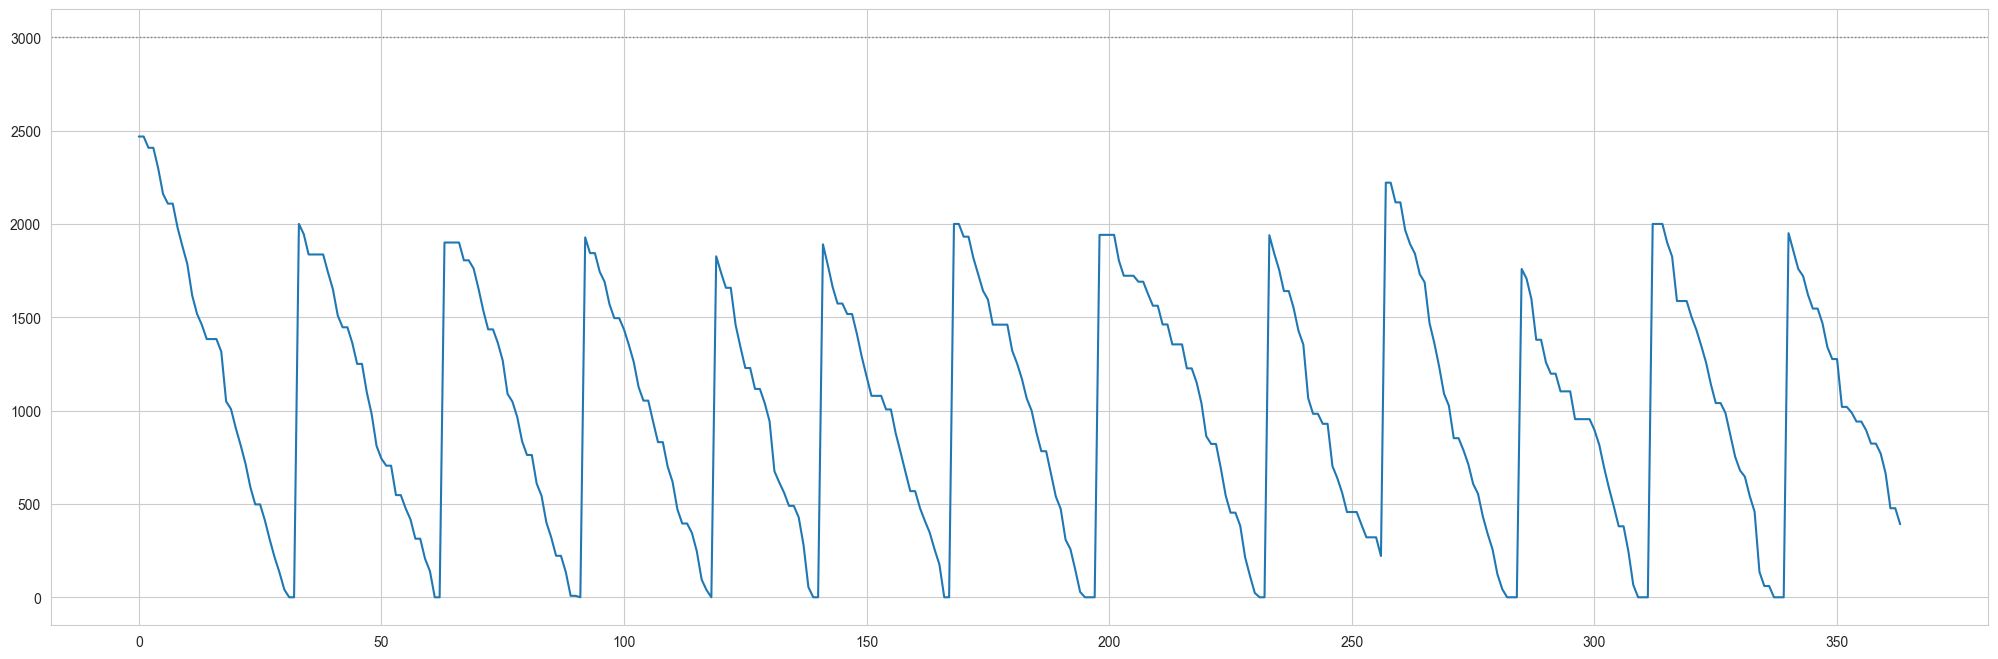

In [44]:
data = cc_monte_carlo_ray(Product(1), 2000, 700)
plt.figure(figsize=(25,8))
plt.plot(data['inv_level'])
plt.axhline(3000, linewidth=1, color="grey", linestyle=":")
plt.show()

In [45]:
data['orders']

[2000, 2000, 2000, 2000, 2000, 2000, 2000, 2000, 2000, 2000, 2000, 2000]

In [47]:
len(data['units_lost'])

22

In [48]:
data = cc_monte_carlo_ray(Product(1), 2000, 700)

In [49]:
len(data['orders'])

12

In [50]:
def cc_mc_simulation(product, q, r, num_simulations=50):
    profit_list = []
    orders_lost_list = []
    for sim in range(num_simulations):
        data = cc_monte_carlo_ray(product, q, r)
        # Calculating the profit
        profit = calculate_profit(data, product)
        profit_list.append(profit)
        # Calculating the orders lost
        total_demand = sum(data['daily_demand'])
        unsold_orders = sum(data['units_lost'])
        orders_lost_list.append(unsold_orders/total_demand)

    return profit_list, orders_lost_list

In [51]:
p_list, o_list = cc_mc_simulation(Product(1), 2000, 700, 1000)
print([np.mean(p_list), np.std(p_list)])

[109373.38875785621, 8666.885893761115]


In [52]:
def continous_review(product, q_guess, r_guess):
    q_low = q_guess - 1000
    q_high = q_guess + 1000
    q_range = [i for i in range(int(q_low), int(q_high), 10)]

    r_low = r_guess - 300
    r_high = r_guess + 300
    r_range = [i for i in range(int(r_low), int(r_high), 10)]

    review_dict = {}

    for q in q_range:
        for r in r_range:
            p_list, o_list = cc_mc_simulation(product, q, r)
            review_dict[(q, r)] = (
                np.mean(p_list), np.quantile(p_list, 0.05), np.quantile(p_list, 0.95), np.std(p_list), np.mean(o_list))

    return review_dict

#review = continous_review(Product(1), 2000, 700)

In [53]:
cc_review = continous_review(Product(1), 2000, 700)

In [54]:
from mpl_toolkits.mplot3d import Axes3D

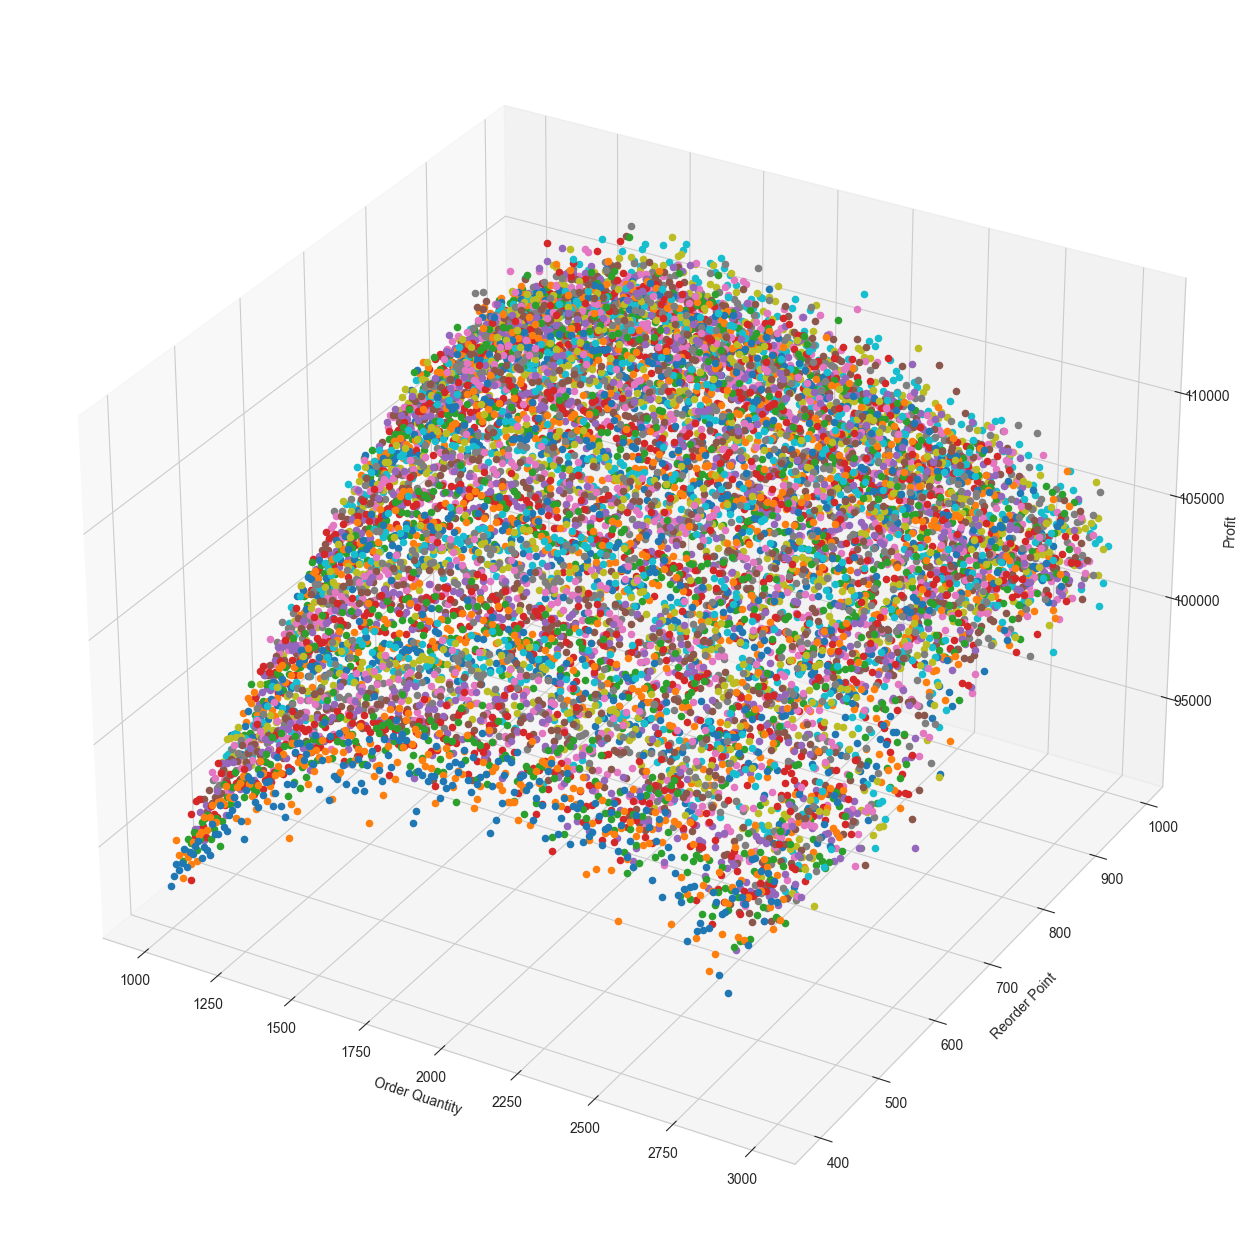

In [56]:
fig = plt.figure(figsize=(24,16))
ax = fig.add_subplot(111, projection='3d')

for key, val in cc_review.items():
    ax.scatter(key[0], key[1], val[0], marker = 'o')

ax.set_xlabel('Order Quantity')
ax.set_ylabel('Reorder Point')
ax.set_zlabel('Profit')

plt.show()

Finding Optimum Values of Q and r

In [72]:
max(cc_review.items(), key=operator.itemgetter(1))

((1770, 840),
 (114992.777220414,
  104024.91520485612,
  126123.64584657777,
  7003.947426646004,
  0.02698062500018293))